# all converted to mongo db

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports cleaned']  

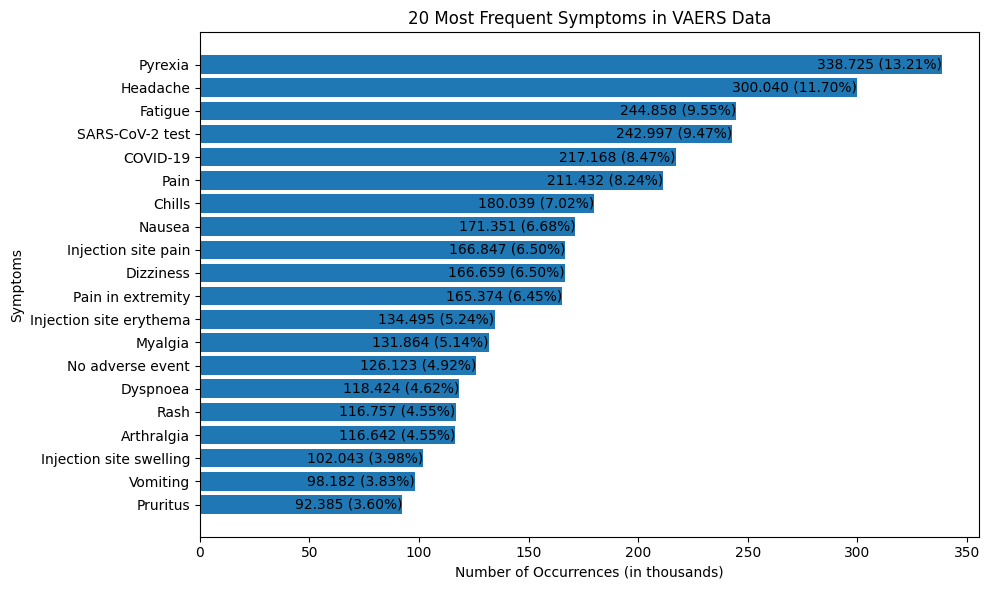

In [20]:
pipeline = [
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]
# Query the database for all documents
total_reports = collection.count_documents({})

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms in VAERS Data')
    plt.xlabel('Number of Occurrences (in thousands)')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()
    def thousands_formatter(x):
        return f'{x/1000:.0f}'

# Apply the custom formatter to the y-axis
    plt.gca().xaxis.set_major_formatter(thousands_formatter)

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_alltime.png')

    plt.show()
else:
    print("No data found.")

# Most common symptoms from 1990 to 2023

# Now for people that got vaccinated with the COVID-19 vaccine

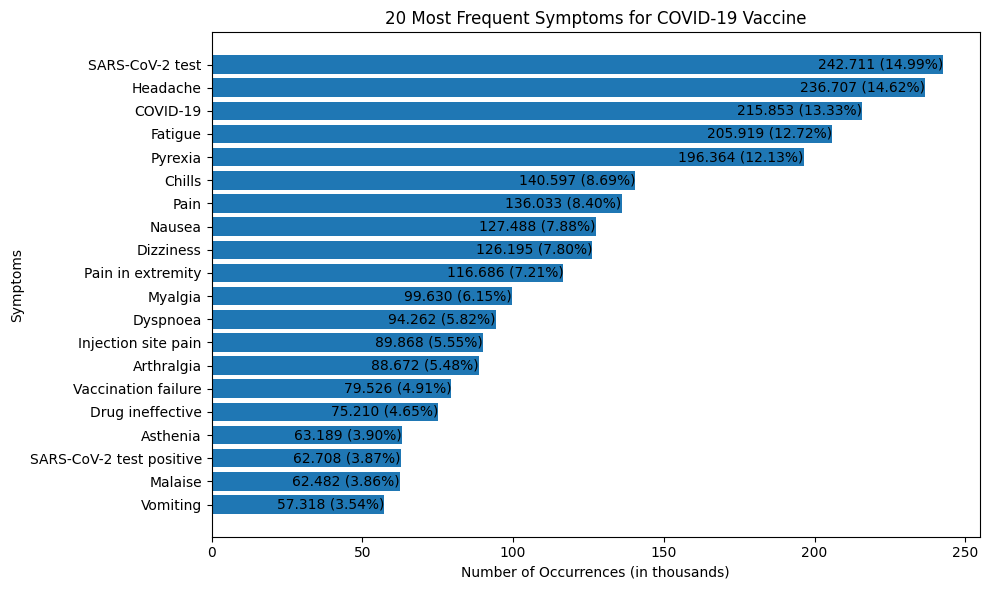

In [21]:
import re

# Count total reports containing COVID in vax_data.VAX_TYPE
total_reports = collection.count_documents({"vax_data.VAX_TYPE": {"$regex": "COVID"}})

pipeline = [
    # Match documents where vax_data.VAX_TYPE contains "COVID"
    {"$match": {"vax_data.VAX_TYPE": {"$regex": "COVID"}}},  
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms for COVID-19 Vaccine')
    plt.xlabel('Number of Occurrences (in thousands)')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()
    def thousands_formatter(x):
        return f'{x/1000:.0f}'

# Apply the custom formatter to the y-axis
    plt.gca().xaxis.set_major_formatter(thousands_formatter)

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID.png')

    plt.show()
else:
    print("No data found.")

# Now for every other vaccine besides COVID-19

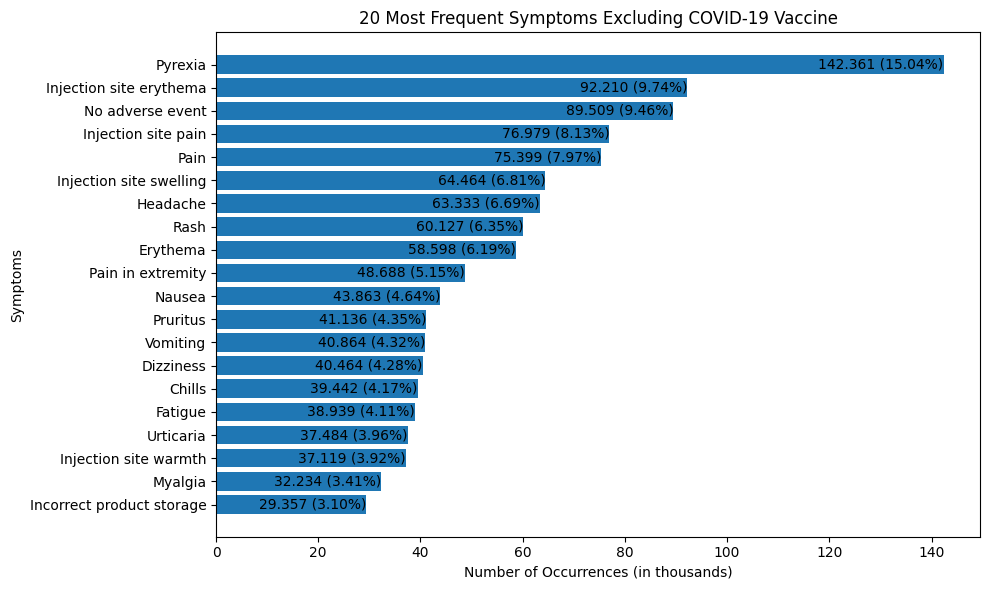

In [22]:
# Count total reports not containing COVID in vax_data.VAX_TYPE
total_reports = collection.count_documents({"vax_data.VAX_TYPE": {"$not": re.compile("COVID")}})

pipeline = [
    # Match documents where at least one vaccine in vax_data.VAX_TYPE is non-COVID
    {"$match": {"vax_data.VAX_TYPE": {"$not": re.compile("COVID")}}},  
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms Excluding COVID-19 Vaccine')
    plt.xlabel('Number of Occurrences (in thousands)')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()
    def thousands_formatter(x):
        return f'{x/1000:.0f}'

# Apply the custom formatter to the y-axis
    plt.gca().xaxis.set_major_formatter(thousands_formatter)

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_ExcludingCOVID.png')

    plt.show()
else:
    print("No data found.")

# Symptoms per manufacturer

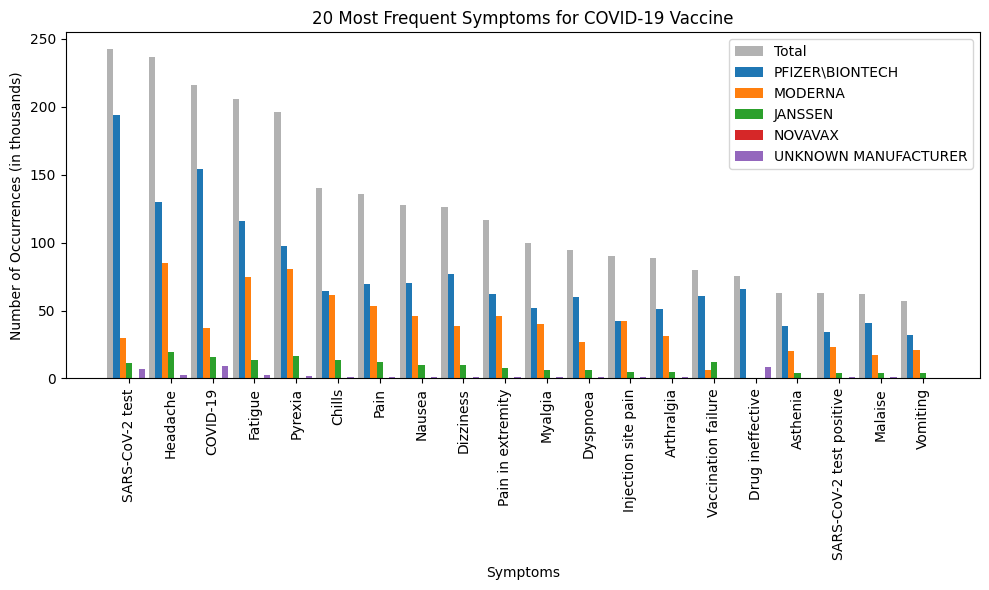

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Specify the manufacturers to include
target_manufacturers = ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'NOVAVAX', 'UNKNOWN MANUFACTURER']

# Initialize a dictionary to store symptoms per manufacturer
symptoms_per_manufacturer = {manu: {} for manu in target_manufacturers}

# Query the database for documents with specified manufacturers and VAX_TYPE including 'COVID'
query = {
    'vax_data.VAX_MANU': {'$in': target_manufacturers},
    'vax_data.VAX_TYPE': {'$regex': 'COVID', '$options': 'i'}
}
projection = {'VAERS_ID': True, 'vax_data.VAX_MANU': True, 'symptoms': True}
documents_cursor = collection.find(query, projection)

# Process documents to count symptoms
for document in documents_cursor:
    # Extract all VAX_MANU entries for the document
    manufacturers = [entry['VAX_MANU'] for entry in document.get('vax_data', []) if 'VAX_MANU' in entry]

    # Intersect the manufacturers list with the target manufacturers
    intersected_manufacturers = set(manufacturers).intersection(set(target_manufacturers))

    # If there's no intersection, skip this document
    if not intersected_manufacturers:
        continue
    
    # Assume that a document cannot have more than one vaccine manufacturer from the target list
    manufacturer = intersected_manufacturers.pop()
    
    # Ensure symptoms_list is always a list
    symptoms_list = document.get('symptoms', [])
    if not isinstance(symptoms_list, list):
        symptoms_list = [symptoms_list]  # Convert to list if not already
    
    for symptom in symptoms_list:
        if symptom:  # Check if symptom is not empty
            symptoms_per_manufacturer[manufacturer].setdefault(symptom, 0)
            symptoms_per_manufacturer[manufacturer][symptom] += 1

# Convert the dictionary to DataFrame
df = pd.DataFrame(symptoms_per_manufacturer).fillna(0)

# Sum the counts of each symptom across all manufacturers
df['Total'] = df.sum(axis=1)

# Select the top 20 most frequent symptoms
top_20_symptoms = df['Total'].sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.15
index = range(len(top_20_symptoms))

# Calculate total counts for top 20 symptoms
total_counts = df['Total'][top_20_symptoms.index]

# Plot total bar first
plt.bar(index, total_counts, width=bar_width, label='Total', color='k', alpha=0.3)

# Plot bars for individual manufacturers
for i, manufacturer in enumerate(target_manufacturers):
    if manufacturer in df.columns:
        symptom_counts = [df.at[symptom, manufacturer] for symptom in top_20_symptoms.index]
        plt.bar([x + bar_width * (i + 1) for x in index], symptom_counts, width=bar_width, label=manufacturer)

# Adding labels and title
plt.xlabel('Symptoms')
plt.ylabel('Number of Occurrences (in thousands)')
plt.title('20 Most Frequent Symptoms for COVID-19 Vaccine')
plt.xticks([x + bar_width * (len(target_manufacturers) + 1) / 2 for x in index], top_20_symptoms.index, rotation=90)  # Rotate x-axis labels for better visibility
plt.legend()  # Show legend

# Define custom formatter function for y-axis
def thousands_formatter(x):
    return f'{x/1000:.0f}'

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(thousands_formatter)

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID_byManufacturer_total.png')
plt.show()

In [14]:
df

,PFIZER\BIONTECH,MODERNA,JANSSEN,NOVAVAX,UNKNOWN MANUFACTURER,Total
Hypoaesthesia,26637.0,11211.0,3182.0,18.0,284.0,41332.0
Injection site hypoaesthesia,645.0,431.0,91.0,3.0,7.0,1177.0
Headache,129578.0,85361.0,19469.0,47.0,2252.0,236707.0
Erythema,14200.0,17992.0,1042.0,8.0,256.0,33498.0
Feeling hot,10453.0,6647.0,1468.0,6.0,170.0,18744.0
...,...,...,...,...,...,...
Rheumatoid lung,0.0,0.0,0.0,0.0,1.0,1.0
Product distribution issue,0.0,0.0,0.0,0.0,1.0,1.0
Marginal zone lymphoma stage I,0.0,0.0,0.0,0.0,1.0,1.0
Infusion site rash,0.0,0.0,0.0,0.0,1.0,1.0


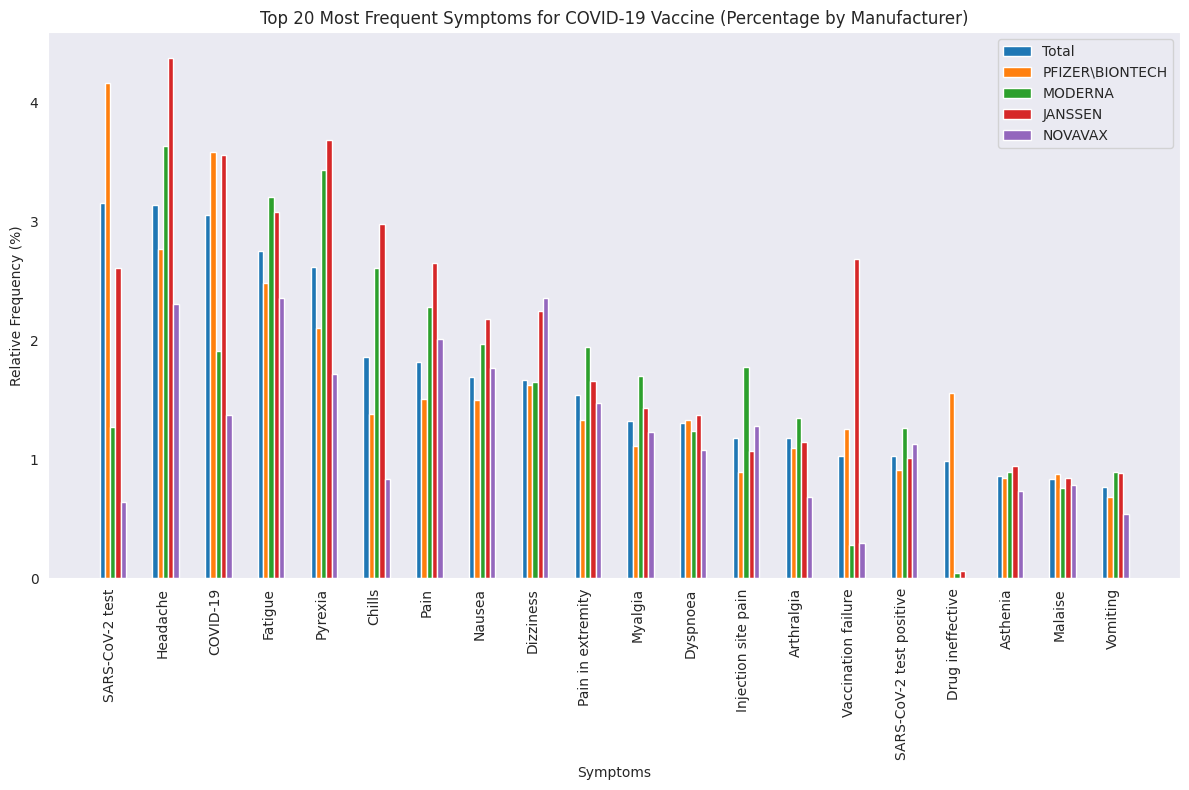

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the target manufacturers
target_manufacturers = ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'NOVAVAX']

# Define the aggregation pipeline
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID", "$options": "i"}  # Filter documents with COVID vaccine type
        }
    },
    {
        "$match": {
            "vax_data.VAX_MANU": {"$in": target_manufacturers}  # Filter documents by specified manufacturers
        }
    },
    {
        "$project": {
            "manufacturer": "$vax_data.VAX_MANU",
            "symptoms": "$symptoms"
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline, allowDiskUse=True)

# Initialize a dictionary to store symptoms per manufacturer
symptoms_per_manufacturer = {manu: [] for manu in target_manufacturers}

# Process the results to populate the symptoms per manufacturer dictionary
for doc in results:
    manufacturer = doc["manufacturer"]
    symptoms_list = doc["symptoms"]
    
    # Check if symptoms_list is iterable
    if isinstance(symptoms_list, list):
        # Append the list of symptoms for the manufacturer
        symptoms_per_manufacturer[manufacturer].extend(symptoms_list)

# Convert the lists of symptoms per manufacturer to DataFrame
df = pd.DataFrame({manufacturer: pd.Series(symptoms).explode().reset_index(drop=True) for manufacturer, symptoms in symptoms_per_manufacturer.items()})

# Calculate the frequency of each symptom for each manufacturer
df_counts = df.apply(pd.Series.value_counts)

# Aggregate the total occurrences of each symptom across all manufacturers
total_symptoms_counts = df_counts.sum(axis=1)

# Select the top 20 most frequent symptoms across all manufacturers
top_20_total_symptoms = total_symptoms_counts.nlargest(20)

# Calculate the percentage of each symptom for each manufacturer
df_percentage = (df_counts / df_counts.sum()) * 100

# Plotting
plt.figure(figsize=(12, 8))

# Calculate the positions for bars
bar_width = 0.1
total_bar_positions = range(len(top_20_total_symptoms))
manufacturer_bar_positions = [x + bar_width for x in total_bar_positions]

# Plot total bar
total_symptom_percentages = [(total_symptoms_counts[symptom] / total_symptoms_counts.sum()) * 100 if symptom in total_symptoms_counts.index else 0 for symptom in top_20_total_symptoms.index]
plt.bar(total_bar_positions, total_symptom_percentages, width=bar_width, label='Total')

# Plot bars for individual manufacturers
for i, manufacturer in enumerate(target_manufacturers):
    if manufacturer in df_percentage.columns:
        symptom_percentages = [df_percentage.at[symptom, manufacturer] if symptom in df_percentage.index else 0 for symptom in top_20_total_symptoms.index]
        plt.bar([x + bar_width * (i + 1) for x in total_bar_positions], symptom_percentages, width=bar_width, label=manufacturer)

# Adding labels and title
plt.xlabel('Symptoms')
plt.ylabel('Relative Frequency (%)')
plt.title('Top 20 Most Frequent Symptoms for COVID-19 Vaccine (Percentage by Manufacturer)')
plt.xticks([x + bar_width * (len(target_manufacturers) - 1) / 2 for x in total_bar_positions], top_20_total_symptoms.index, rotation=90)  # Rotate x-axis labels for better visibility
plt.legend()  # Show legend
plt.grid(which='both')  # Set grid for both major and minor ticks on y-axis
plt.tight_layout()
plt.savefig(f'/home/sebastian/Documents/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID_byManufacturer_cleaned.pdf')
plt.show()


In [16]:
df_percentage

,PFIZER\BIONTECH,MODERNA,JANSSEN,NOVAVAX,UNKNOWN MANUFACTURER
17-hydroxyprogesterone,0.000270,0.000041,NaN,NaN,NaN
3-Dimensional vasculography,0.000021,NaN,0.000223,NaN,NaN
5'nucleotidase,0.000062,NaN,NaN,NaN,NaN
5-alpha reductase inhibition therapy,0.000021,NaN,NaN,NaN,NaN
5-hydroxyindolacetic acid,0.000104,NaN,NaN,NaN,NaN
...,...,...,...,...,...
pH body fluid increased,0.000041,0.000041,NaN,NaN,NaN
pH urine,0.003173,0.001428,0.000891,NaN,NaN
pH urine abnormal,0.000062,NaN,NaN,NaN,NaN
pH urine increased,0.000062,0.000163,0.000223,NaN,NaN


In [17]:
df_counts.sum()

PFIZER\BIONTECH         4821625.0
MODERNA                 2451657.0
JANSSEN                  449147.0
NOVAVAX                    2033.0
UNKNOWN MANUFACTURER      57402.0
dtype: float64

In [18]:
pipeline = [
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"},
            "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER",
            "symptoms": {"$exists": True}  # Ensure the document has a "symptoms" field
        }
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

unique_vax_types = set()

# Iterate through each document in the result
for document in result:
    # Check if 'vax_data' exists in the document
    if 'vax_data' in document:
        # Iterate through each entry in 'vax_data'
        for entry in document['vax_data']:
            # Extract the 'VAX_TYPE' value and add it to the set
            if 'VAX_TYPE' in entry:
                unique_vax_types.add(entry['VAX_TYPE'])

# Print the unique VAX_TYPE values
print("Unique VAX_TYPE values:")
for vax_type in unique_vax_types:
    print(vax_type)

Unique VAX_TYPE values:
ADEN_4_7
DTAPHEPBIP
DTOX
FLUA3
PNC20
TBE
HPV2
FLUC4
VARZOS
DTAPIPV
PNC15
DTAP
RVX
IPV
MMRV
HEP
TYP
TD
SMALL
YF
DTP
HEPAB
JEVX
PNC
MEA
MMR
DT
PPV
MEN
CHOL
HEPA
DTAPIPVHIB
MENB
FLUX(H1N1)
TDAP
HPVX
PNC13
RAB
RSV
UNK
MU
DTPIPV
FLUR4
DTIPV
FLUX
FLU4
RV1
SMALLMNK
FLU3
MNQ
HPV4
FLUC3
BCG
FLUA4
DTPPVHBHPB
FLUN3
HIBV
HPV9
VARCEL
COVID19-2
COVID19
CEE
TTOX
MENHIB


In [19]:
# Define the aggregation pipeline
pipeline = [
    {
        "$unwind": "$vax_data"  # Deconstruct the 'vax_data' array field
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"},  # Filter documents with COVID19 vaccine type
            "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER"  # Filter documents where manufacturer is unknown
        }
    },
    {
        "$project": {
            "symptoms": 1  # Project the "symptoms" field
        }
    },
    {
        "$unwind": "$symptoms"  # Unwind the "symptoms" array
    },
    {
        "$group": {
            "_id": None,
            "total_symptoms": {"$sum": 1}  # Count the total number of symptoms
        }
    }
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Print the count of symptoms for COVID vaccines with unknown manufacturer
if result:
    print(f"Number of symptoms for COVID vaccines with unknown manufacturer: {result[0]['total_symptoms']}")
else:
    print("No documents found matching the criteria.")


Number of symptoms for COVID vaccines with unknown manufacturer: 57402


In [5]:
total_symptoms_counts

17-hydroxyprogesterone                   14.0
3-Dimensional vasculography               2.0
5'nucleotidase                            3.0
5-alpha reductase inhibition therapy      1.0
5-hydroxyindolacetic acid                 5.0
                                        ...  
pH body fluid increased                   3.0
pH urine                                192.0
pH urine abnormal                         3.0
pH urine increased                        8.0
pH urine normal                         255.0
Length: 15537, dtype: float64

In [2]:
# Define the aggregation pipeline
pipeline = [
    { "$unwind": "$symptoms" },  # Unwind the symptoms array
    { "$group": {
        "_id": "$symptoms",  # Group by each unique symptom
        "count": { "$sum": 1 }  # Count occurrences of each symptom
    }},
    { "$group": {
        "_id": None,  # Group all results into one document
        "total_unique_symptoms": { "$sum": 1 }  # Count the number of unique symptoms
    }}
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Print the result
if result:
    print("Total unique symptoms across all reports:", result[0]["total_unique_symptoms"])
else:
    print("No data found.")

Total unique symptoms across all reports: 17715
